<a href="https://colab.research.google.com/github/HyunMooKim/python-Data/blob/main/%EB%8B%A4%EC%A4%91%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#회귀분석 전체 모델


In [ ]:
'''
금가격 예측을 위한 다중 회귀 분석.
금 가격에 영향을 미칠만한 변수 데이터를 엑셀로 다운받아, 이를 바탕으로 다중회귀 분석을 진행하였다.
분석을 진행하며 다음과 같은 기준으로 독립변수로서의 적절성을 판단해 보았다.
0.일정한 방향으로만 지속적으로 움직인 경우 엑셀에서 차분했다. -> 파이썬에서 경향성이 없어질 때까지 차분하게 하면 더 좋을듯
1.회귀모델의 p-value
2.변수끼리의 상관계수
3.VIF 다중공선성 판단
4.granger causalty
5.시각화 후 직관적 판단

이런 기준으로 변수를 살펴보고 난 후,
다시 회귀분석으로 돌아와 적절하다고 판단되는 변수들을 남기고
앞으로 2달 후 금 가격이 어떻게 변할지를 판단해 보았다.

설명력이 높아 보이는 변수들 중
granger causalty검사에서 오히려 종속변수로서 작용하는 것으로 판명난 경우도 있었고,
VIF가 너무 높아 활용하기 어려운 경우, 또는 시각화해보면 단순히 계속 상승하기만 했는데
설명력이 있는 것처럼 수치가 나오는 경우 등이 있었다.

시장이 꽤나 효율적인 것으로 보인다. 조건을 모두 만족시키며 설명력도 높은 변수는 거의 없었다.
'''

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

############기본회귀분석#############
#전체 변수 "WTI","GAS","FED rate","CPI","CPI_d","DGS10","dollar","S&P500","goldETF", "gold spot", "silver","gold mining","VIX","CRB"
#1차 발표 선택 "DGS10","S&P500","VIX","CRB","goldETF"
#2차 수정 "FED rate", "CPI_d", "DGS10","dollar","S&P500","VIX"     - "goldETF"
#이론과 달랐던 것? "goldETF",
gold = pd.read_excel("regression_2.xlsx")

'''
##전처리 결측치 제거 ##
gold = gold.iloc[ : ,6 : ]
gold= gold.dropna(axis = 0)
'''
#분석 변수 설정: 독립-종속
x_data = gold[ [ "FED rate","cpi_d","DGS10","dollar","S&P500", "VIX"]]
target = gold[["gold spot"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
print(fitted_multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:              gold spot   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     106.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           3.94e-28
Time:                        12:35:04   Log-Likelihood:                -346.05
No. Observations:                  61   AIC:                             706.1
Df Residuals:                      54   BIC:                             720.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -148.4837    260.533     -0.570      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
############예측해보기 특정 지점##########
#각 변수 값  fed rate 4, cpi_d 1.2 , DGS10 - 4.14  dollar-109.64   S&P500:3828.11  VIX: 25.54

fitted_multi_model = LinearRegression()
fitted_multi_model.fit(x_data, target)

my_predict=[[4, 1.2 , 4.14 , 109.64 ,3828.11, 25.54]]

x = float(fitted_multi_model.predict(my_predict))
print(x)

1348.8991322025586


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
############예측해보기 범위 ##########
fitted_multi_model  = LinearRegression()
fitted_multi_model.fit(x_data, target)

max = -1
min = 1000000000000
for i in range( 16, 19): #DGS10
  for j in range(3450, 3751 ,150 ): #S&P
    for l in range(30, 37, 2): #VIX
      for m in range(275, 326, 25): #CRB
        for k in range(35000000,40000001,2500000): #ETF
          my_predict = [[i*0.25,j,l,m,k]]
          x = float(fitted_multi_model.predict(my_predict))
          if( max <= x ):
            max = x
          if(min >= x ):
            min = x

print(max, min)

#추세/ 계절성 검사

In [ ]:
! pip install statsmodels


In [ ]:
## UDF for ADF test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pandas as pd

gold = pd.read_excel("regression_2.xlsx")

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries.values)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if(dfoutput.loc['p-value']>= 0.05):      ##문제있는 변수만 보기
      print('adf검사',dfoutput.loc['p-value'])


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"] )

    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if(kpss_output.loc['p-value']<= 0.05):
      print('kpss검사',kpss_output.loc['p-value'])

df = gold.iloc[:,[i]]
adf_test(df)

for i in range(2,17):
  df = gold.iloc[:,[i]]
  print(df.columns)
  print('ADF')
  adf_test(df)
  print('KPSS')
  kpss_test(df)
  print()
  print()

#다중공선성 분석1 - 상관계수

In [ ]:
#############상관계수 파악 ##############
data = gold[["DGS10","S&P500","VIX","CRB","goldETF"]]
# 상수항 추가

data.corr()

NameError: ignored

#다중공선성 분석2 -VIF


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_excel('regression.xlsx')

#########  VIF 검사  #########
X_train = df[["DGS10","S&P500","VIX","CRB","goldETF"]] ###VIF 변수 넣는 곳!###
vif = pd.DataFrame()
vif["VIF_Factor"] = [ variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

#그레인저 분석

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

df = pd.read_excel('regression.xlsx')

'''  ##gold mining 할땐 이거 넣어야함
##전처리 결측치 제거 ##
df = gold.iloc[ : ,6 : ]
df= df.dropna(axis = 0)
'''
##############perform Granger-Causality test##############

df= df.dropna(axis = 0)

for i in range(6,19):
  data = df.iloc[: , [20,i]]
  print()
  print()
  print()
  print(data.columns)
  grangercausalitytests(data, maxlag=[3])  ##뒤에 들어가는 게 독립변수 역할!
  data = df.iloc[:, [i, 20]]
  grangercausalitytests(data, maxlag=[3])  ##maxlag => [7] 이렇게하면 7 하나만,  그냥 7 넣으면 1부터 7까지 다 나옴





Index(['gold spot', 'WTI'], dtype='object')

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0471  , p=0.9863  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=0.1659  , p=0.9829  , df=3
likelihood ratio test: chi2=0.1656  , p=0.9829  , df=3
parameter F test:         F=0.0471  , p=0.9863  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4204  , p=0.2510  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=5.0068  , p=0.1713  , df=3
likelihood ratio test: chi2=4.7577  , p=0.1904  , df=3
parameter F test:         F=1.4204  , p=0.2510  , df_denom=40, df_num=3



Index(['gold spot', 'GAS'], dtype='object')

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1797  , p=0.3296  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=4.1583  , p=0.2449  , df=3
likelihood ratio test: chi2=3.9845  , p=0.2631  , df=3
parameter F test:         F=1.1797  , p=0.3296  , df_denom=40, df_num=3

Grang

#그래프 분석

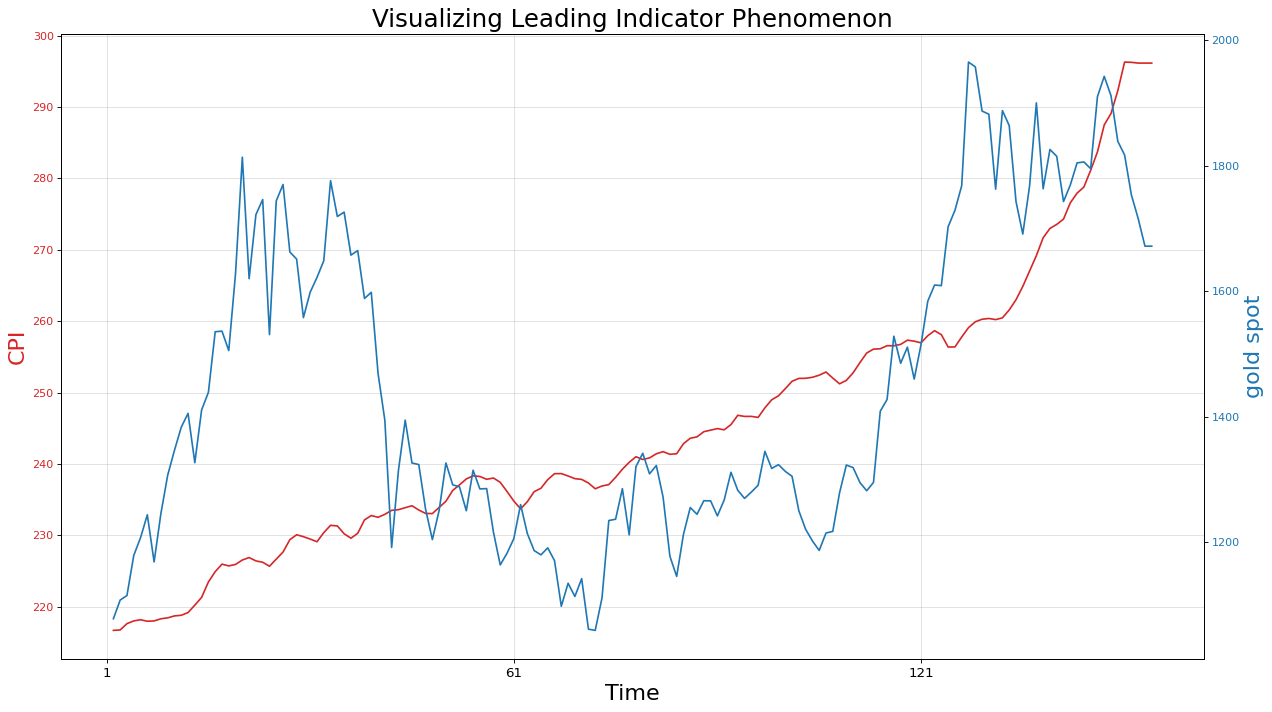

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

############## 시간에 따라 변하는 두 변수 시각화 자료 ######################

df = pd.read_excel("regression.xlsx")

##변수 넣는 곳!!##
x = df['time']
y1 = df['CPI']
y2 = df['gold spot']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('CPI', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("gold spot", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
ax2.set_title("Visualizing Leading Indicator Phenomenon", fontsize=22)
fig.tight_layout()
plt.show()